# First order (Euler - Godunov) Non Linear FV Shallow Water model

* [Riemann solvers](#solver)
* [Interface flux functions](#flux)
* [Boundary conditions](#bcs)
* [dt step](#setdt)
* [Driver function](#iterate)

[Verification: 1D Dambreak](#case1)
* [Data](#c1-data)
* [Simulation with closed boundaries](#c1-sim_closed)
* [Simulation with open boundaries](#c1-sim_open)

[Conclusions](#conclusions)
* [SurfWB-UC results](#surfwb-uc_results)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="solver"> </a>
## Riemann solvers

The one I originally programed at the beginning of the project 

In [2]:
%%writefile nswe1.py 

import numpy as np
g = 9.81
def roe(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if hl<0 or hr<0:
        print hl,hr
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    return hs,us

Overwriting nswe1.py


A copy from the code of Marche, version 1.1.2 (26 novembre 2008)

In [3]:
%%writefile nswe1.py -a

import numpy as np
g = 9.81
def roe_surf(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    kappa = 1e-10
    if hl<0 or hr<0:
        print hl,hr
    
    cl = np.sqrt(g*hl)
    ul = 0
    if hl>0: ul = hul/hl
    
    cr = np.sqrt(g*hr)
    ur = 0
    if hr>0: ur = hur/hr
        
    cm = 0.5*(cl + cr)
    um = 0.5*(ul + ur)
    
    lambda1 = um - cm
    lambda3 = um + cm
    
    cs = 0.0
    us = 0.0
    if hl > kappa or hr > kappa:
        if lambda1 > 0.0:
            cs = cl
            us = ul
        elif lambda3 < 0.0:
            cs = cr
            us = ur
        else:
            cs = cm - 0.25*(ur-ul)
            us = um  -(cr-cl)
        
        #entropy fix
        if ul - cl < 0 and ur - cr > 0 :
            cs = 0.5*(cl + cr)
            us = 0.5*(ul + ur)
        if ul + cl < 0 and ur + cr > 0 :
            cs = 0.5*(cl + cr)
            us = 0.5*(ul + ur)
        
    #detect dry middle state
    if cs <= kappa:
        hs = kappa
        us = 0.0
    else:
        hs = cs**2/g
        
    return hs,us

Appending to nswe1.py


A verion that is in the middle between both of them. They are mathematically the same, but with slightly different programming

In [4]:
%%writefile nswe1.py -a

import numpy as np
g = 9.81
def roe1(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    kappa = 1e-10
    if hl<0 or hr<0:
        print hl,hr
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)

    ws1 = 0.0
    ws2 = 0.0
    hs = 0.0
    us = 0.0
    if hl>kappa or hr>kappa:
        if l1>0:
            us = ul
            hs = hl
        elif l2<0:
            us = ur
            hs = hr
        else:
            ws1 = wr1    
            ws2 = wl2
            us = 0.5*(ws1+ws2)
            hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if ul - np.sqrt(g*hl)<0 and ur - np.sqrt(g*hr) > 0:
        us = uhat
        hs = hhat
        
    if ul + np.sqrt(g*hl)<0 and ur + np.sqrt(g*hr)    > 0:
        us = uhat
        hs = hhat
    return hs,us

Appending to nswe1.py


<a id="flux"> </a>

# Interface flux functions

In [5]:
%%writefile nswe1.py -a

def flux(h,u):
    """
        h,u escalares, returna F(U)
    """
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

Appending to nswe1.py


<a id="interflux"></a>

$f_i$ es the flux between cells $i$ and $i+1$

In [6]:
%%writefile nswe1.py -a

def fluxes_matrix(h,hu,n,riemann_solver):
    """
        Receives full matrices h,hu (nt,nx)
        including ghost cells   and calculates returns
        fluxes for inner cells  interfaces in row of index n
    """
    nx = h.shape[1]
    f = np.zeros((2,nx-1))
    for i in range(nx-1):
        hs,us = riemann_solver(h[n,i],hu[n,i],h[n,i+1],hu[n,i+1])
        f[:,i] = flux(hs,us)
    return f

Appending to nswe1.py


In [7]:
%%writefile nswe1.py -a

def fluxes_row(h0,hu0,nx):
    """
        Like fluxes0, but for a given row 
        h0, hu0 of size (nx,).
    """
    f = np.zeros((2,nx-1))
    for i in range(nx-1):
        hs,us = roe(h0[i],hu0[i],h0[i+1],hu0[i+1])
        f[:,i] = flux(hs,us)
    return f

Appending to nswe1.py


<a id="bcs"> </a>
## Boundary conditions

In [8]:
%%writefile nswe1.py -a

def bcs_closed(h,hu,n):
    """ 
        Applies first order "closed" boundary
        conditions on row n of h and hu. 
        This is, homogeneous Neumann and Dirichlet for h and hu
        respectively
    """
    hb = 1.*h
    hub = 1.*hu
    hb[n,0] = h[n,1]
    hub[n,0] = -hu[n,1]
    hb[n,-1] = h[n,-2]
    hub[n,-1] = -hu[n,-2]    
    return hb,hub

Appending to nswe1.py


In [9]:
%%writefile nswe1.py -a

def bcs_open(h,hu,n):
    """ 
        Applies first order "open" boundary
        conditions on row n of h and hu. 
        This is, homogeneous Neumann for h and hu
        respectively
    """
    hb = 1.*h
    hub = 1.*hu
    hb[n,0] = h[n,1]
    hub[n,0] = hu[n,1]
    hb[n,-1] = h[n,-2]
    hub[n,-1] = hu[n,-2]    
    return hb,hub

Appending to nswe1.py


<a id="setdt"></a>
## $\Delta t$ step

In [10]:
%%writefile nswe1.py -a

def setdt(h,hu,n,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)
    s = np.max(np.abs(u_n)+np.sqrt(9.81*h[n,:]))
    dt = cfl*dx/np.max(s)
    return dt

Appending to nswe1.py


<a id="iterate"></a>
## Simulation main function

In [11]:
%%writefile nswe1.py -a

def simulate(h,hu,bcs,dx,cfl,t0,nt,riemann_solver):
    """
        Rutina principal que corre la simulacion
    """
    t = np.zeros((nt,))
    for n in range(nt-1):     
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        h,hu = bcs(h,hu,n)    
        f = fluxes_matrix(h,hu,n,riemann_solver)

        h[n+1,1:-1] = h[n,1:-1] -dt/dx*(f[0,1:]-f[0,:-1])
        hu[n+1,1:-1] = hu[n,1:-1] -dt/dx*(f[1,1:]-f[1,:-1])   
        
    return t,h,hu

Appending to nswe1.py


<a id="case1"></a>
# Verification

## 1D Dam break

<a id="c1-data"></a>
## Geometry and initial condition 

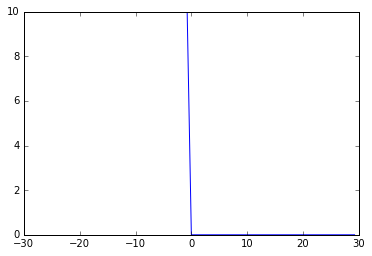

In [12]:
L = 30.
npoints = 40
dx = L/npoints
x = np.arange(-L,L,dx)
dx = np.min(np.diff(x))
nx = x.shape[0]
cfl = 0.45
t0  = 0.
nt = 150

h = np.zeros((nt,x.shape[0]))
hu = np.zeros((nt,x.shape[0]))
h[0,:] = np.where(x<0.0, 10., 0.0001)
hu[0,:] = 0.

plt.plot(x,h[0,:])


<a id="c1-sim_closed"></a>
## Simulation using closed boundaries

In [13]:
import nswe1
tSurf,hSurf,huSurf = nswe1.simulate(h,hu,nswe1.bcs_closed,dx,cfl,t0,nt,nswe1.roe_surf)
t,h,hu = nswe1.simulate(h,hu,nswe1.bcs_closed,dx,cfl,t0,nt,nswe1.roe1)

nswe1.py:220: RuntimeWarning: invalid value encountered in divide
  u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)


### Animation


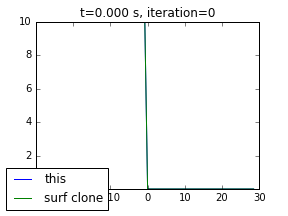
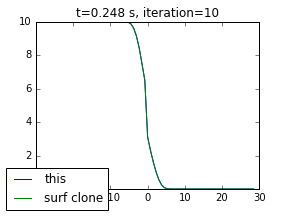
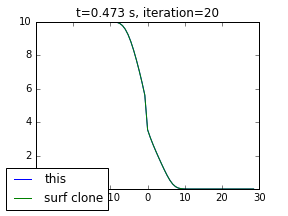
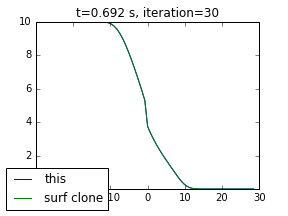
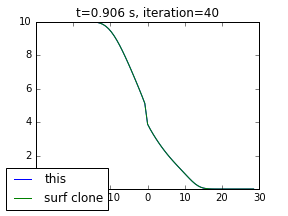
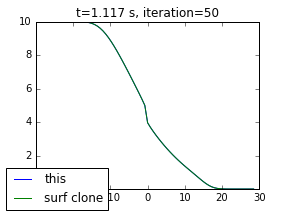
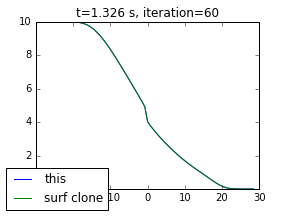
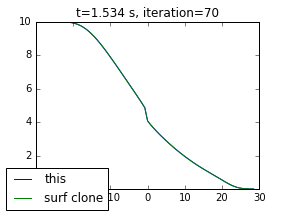
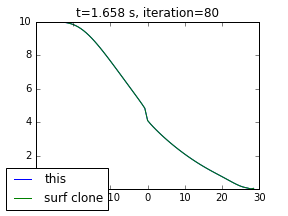
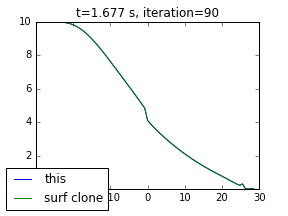
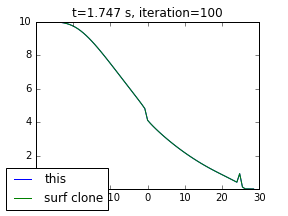
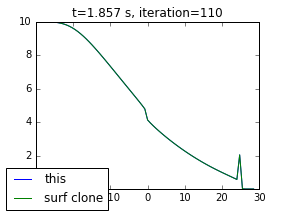
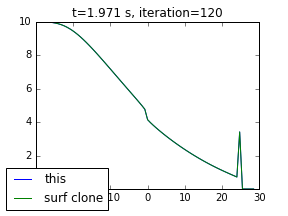
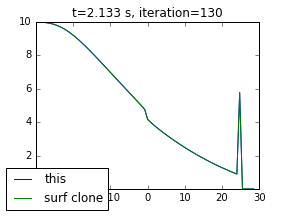
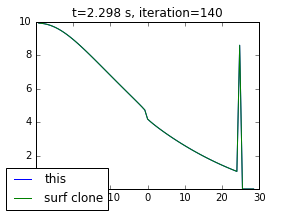

In [14]:
from JSAnimation import IPython_display
from matplotlib import animation
f1 = plt.figure(figsize=(4.,3))
ax1 = f1.add_subplot(111)
lh, = ax1.plot(x[1:-1],h[0,1:-1])
lhsurf, = ax1.plot(x[1:-1],hSurf[0,1:-1])
ax1.set_ylim(0,10)
f1.legend((lh,lhsurf),['this','surf clone'],loc='lower left')


def animate(i):
    i=min(i*10,h.shape[0]-1)
    lh.set_ydata(h[i,1:-1])
    lhsurf.set_ydata(hSurf[i,1:-1])
    ax1.set_title('t=%.3f s, iteration=%i'%(t[i],i))
animation.FuncAnimation(f1,animate,frames=range(nt/10))

<a id="c1-sim_open"></a>
## Simulation using open boundaries

In [15]:
tSurf,hSurf,huSurf = nswe1.simulate(h,hu,nswe1.bcs_open,dx,cfl,t0,nt,nswe1.roe_surf)
t,h,hu = nswe1.simulate(h,hu,nswe1.bcs_open,dx,cfl,t0,nt,nswe1.roe1)

### Animation


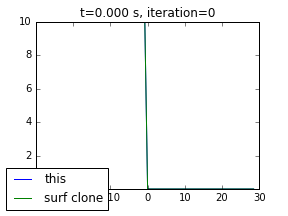
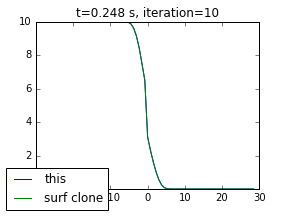
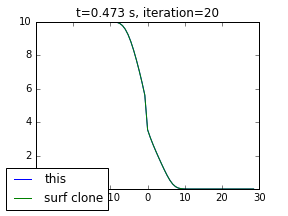
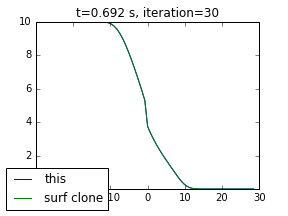
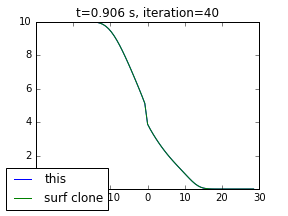
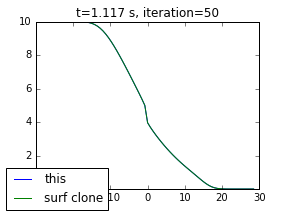
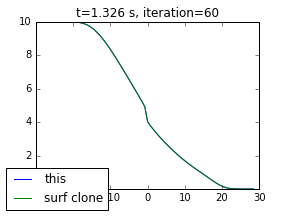
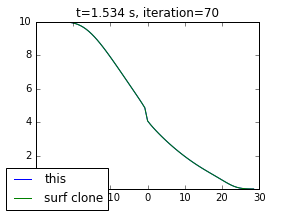
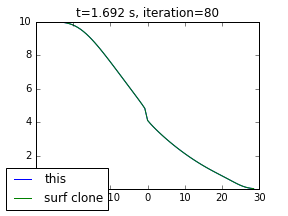
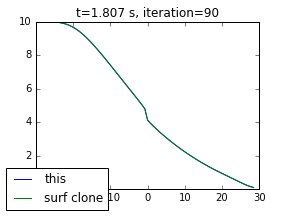
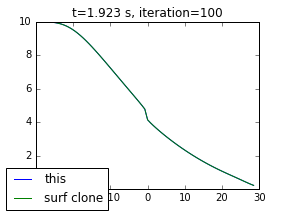
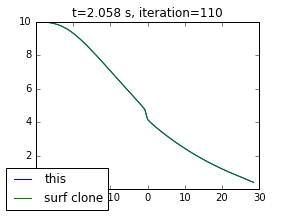
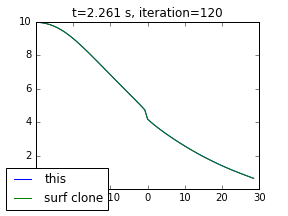
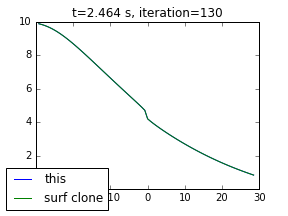
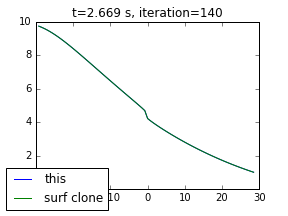

In [16]:
from JSAnimation import IPython_display
from matplotlib import animation
f1 = plt.figure(figsize=(4.,3))
ax1 = f1.add_subplot(111)
lh, = ax1.plot(x[1:-1],h[0,1:-1])
lhsurf, = ax1.plot(x[1:-1],hSurf[0,1:-1])
ax1.set_ylim(0,10)
f1.legend((lh,lhsurf),['this','surf clone'],loc='lower left')


def animate(i):
    i=min(i*10,h.shape[0]-1)
    lh.set_ydata(h[i,1:-1])
    lhsurf.set_ydata(hSurf[i,1:-1])
    ax1.set_title('t=%.3f s, iteration=%i'%(t[i],i))
animation.FuncAnimation(f1,animate,frames=range(nt/10))

In [17]:
np.max(h-hSurf)

7.1054273576010019e-15

<a id="conclusions"></a>
# Conclusions

* Both solvers (fortran surfwb (marche) code and mine) are the same! (finally)...suggests no bugs
* The small jump in the interface is also observed in the SURFWB-UC, see image below
* There are errors from the boundary when using closed boundaries. These errors are also observed in SurfWB-UC (with order 2)
* Those errors no longer appear when using open boundaries

<a id="surfwb-uc_results"></a>
## SurfWB-UC-results

Some fluctuation in the interface, and even in the foot of the wave

<img src=figures/NsweSolvers/surfwb_1dfig000018.png>

It also fails in the boundary

<img src=figures/NsweSolvers/surfwb_1dfig000205.png>